In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#np.set_printoptions(threshold=np.inf)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load the dataset

In [3]:
%cd /content/gdrive/MyDrive/Colab\ Notebooks/predicting_bitcoin_market

/content/gdrive/MyDrive/Colab Notebooks/predicting_bitcoin_market


In [4]:
org_df = pd.read_csv('crypto_data_news_reddit_final_2018.csv',index_col=0)

In [5]:
org_df

,open_BTCUSDT,high_BTCUSDT,low_BTCUSDT,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,gnews_tb_polarity,gnews_tb_subjectivity,gnews_sid_pos,gnews_sid_neg,gnews_sid_neu,gnews_sid_com,reddit_flair,reddit_tb_polarity,reddit_tb_subjectivity,reddit_sid_pos,reddit_sid_neg,reddit_sid_neu,reddit_sid_com
timestamp,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13820.26,13820.26,13498.05,13557.88,210.213142,222.24,590.23000,728.77,625.293831,0.04257,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-01 01:00:00,13557.88,13585.66,13250.50,13262.85,191.931776,215.20,698.36000,724.27,710.891607,0.04257,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,-0.267228,0.046199,0.257910,0.105625,0.091875,0.802500,0.181325
2018-01-01 02:00:00,13262.85,13400.00,13186.02,13320.00,169.456410,215.36,464.55000,722.11,849.257651,0.04257,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,-0.300781,-0.077217,0.273153,0.032000,0.019333,0.948667,0.330133
2018-01-01 03:00:00,13320.00,13515.44,13308.54,13372.00,80.455327,219.30,407.81000,733.19,556.397003,0.04257,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,0.082537,0.242468,0.404416,0.156286,0.025000,0.818714,0.280143
2018-01-01 04:00:00,13372.00,13499.83,13279.50,13483.06,127.212610,223.72,965.39000,738.59,1247.722800,0.04257,0.067753,0.323211,0.065111,0.025222,0.909556,0.624667,0.443654,0.235317,0.321429,0.153143,0.005143,0.841714,0.341757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-20 19:00:00,8099.26,8109.92,8077.82,8086.65,1.910237,54.68,26.89869,174.40,22.319940,-0.07582,0.087598,0.422367,0.090556,0.045111,0.864333,0.457411,0.328284,0.142630,0.506278,0.110429,0.049857,0.839857,0.092543
2019-11-20 20:00:00,8083.19,8111.17,8081.72,8102.66,9.783435,55.06,21.18500,174.45,25.050680,-0.07582,0.087598,0.422367,0.090556,0.045111,0.864333,0.457411,0.000208,0.375000,0.500000,0.314500,0.000000,0.685500,0.511350
2019-11-20 21:00:00,8096.06,8111.25,8078.80,8098.29,1.726209,55.10,16.47622,175.48,32.281160,-0.07582,0.087598,0.422367,0.090556,0.045111,0.864333,0.457411,0.187590,-0.077778,0.144444,0.000000,0.157500,0.842500,-0.248400


In [6]:
org_df.columns

Index(['open_BTCUSDT', 'high_BTCUSDT', 'low_BTCUSDT', 'close_BTCUSDT',
       'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD',
       'volume_ETHUSD', 'gnews_flair', 'gnews_tb_polarity',
       'gnews_tb_subjectivity', 'gnews_sid_pos', 'gnews_sid_neg',
       'gnews_sid_neu', 'gnews_sid_com', 'reddit_flair', 'reddit_tb_polarity',
       'reddit_tb_subjectivity', 'reddit_sid_pos', 'reddit_sid_neg',
       'reddit_sid_neu', 'reddit_sid_com'],
      dtype='object')

# Features engineering

In [7]:
org_df['flair'] = org_df['gnews_flair'] + org_df['reddit_flair']
org_df['tb_polarity'] = org_df['gnews_tb_polarity'] + org_df['reddit_tb_polarity']
org_df['tb_subjectivity'] = org_df['gnews_tb_subjectivity'] + org_df['reddit_tb_subjectivity']
org_df['sid_pos'] = org_df['gnews_sid_pos'] + org_df['reddit_sid_pos']
org_df['sid_neg'] = org_df['gnews_sid_neg'] + org_df['reddit_sid_neg']
org_df = org_df[['close_BTCUSDT', 'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD', 'volume_ETHUSD', 'gnews_flair', 'gnews_tb_polarity', 'gnews_tb_subjectivity', 'gnews_sid_pos', 'gnews_sid_neg']]

In [8]:
org_df

,close_BTCUSDT,volume_BTCUSDT,close_LTCUSD,volume_LTCUSD,close_ETHUSD,volume_ETHUSD,gnews_flair,gnews_tb_polarity,gnews_tb_subjectivity,gnews_sid_pos,gnews_sid_neg
timestamp,,,,,,,,,,,
2018-01-01 00:00:00,13557.88,210.213142,222.24,590.23000,728.77,625.293831,0.04257,0.067753,0.323211,0.065111,0.025222
2018-01-01 01:00:00,13262.85,191.931776,215.20,698.36000,724.27,710.891607,0.04257,0.067753,0.323211,0.065111,0.025222
2018-01-01 02:00:00,13320.00,169.456410,215.36,464.55000,722.11,849.257651,0.04257,0.067753,0.323211,0.065111,0.025222
2018-01-01 03:00:00,13372.00,80.455327,219.30,407.81000,733.19,556.397003,0.04257,0.067753,0.323211,0.065111,0.025222
2018-01-01 04:00:00,13483.06,127.212610,223.72,965.39000,738.59,1247.722800,0.04257,0.067753,0.323211,0.065111,0.025222
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-20 19:00:00,8086.65,1.910237,54.68,26.89869,174.40,22.319940,-0.07582,0.087598,0.422367,0.090556,0.045111
2019-11-20 20:00:00,8102.66,9.783435,55.06,21.18500,174.45,25.050680,-0.07582,0.087598,0.422367,0.090556,0.045111
2019-11-20 21:00:00,8098.29,1.726209,55.10,16.47622,175.48,32.281160,-0.07582,0.087598,0.422367,0.090556,0.045111


# Dataset scalling

In [9]:
dataset = org_df.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(org_df.columns)
print('Number of features', num_of_features)

Number of features 11


# Configuration

In [10]:
expr_name = 'expr_7'
look_back = 24*60 # 60 days, as each entry is for 1 hour
lstm_layers = 32
epochs=5
batch_size=128

# spliting datasets into train and test

In [11]:
train_size_percent = 0.80
pred_col = org_df.columns.get_loc('close_BTCUSDT')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), :]
    dataX.append(a)
    dataY.append(dataset[i + look_back, pred_col])
  return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  13228
Testing dataset length  3308
look_back  1440


# Build the model and train

In [12]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(lstm_layers, input_shape=(look_back,num_of_features)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/5
65/65 [==============================] - 37s 68ms/step - loss: 0.0105 - val_loss: 0.0390
Epoch 2/5
65/65 [==============================] - 3s 53ms/step - loss: 0.0128 - val_loss: 0.0209
Epoch 3/5
65/65 [==============================] - 3s 54ms/step - loss: 0.0044 - val_loss: 0.0113
Epoch 4/5
65/65 [==============================] - 3s 53ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 5/5
65/65 [==============================] - 3s 53ms/step - loss: 8.2473e-04 - val_loss: 0.0060


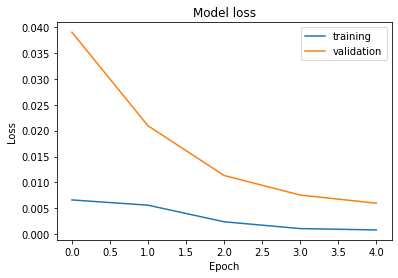

In [13]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [14]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

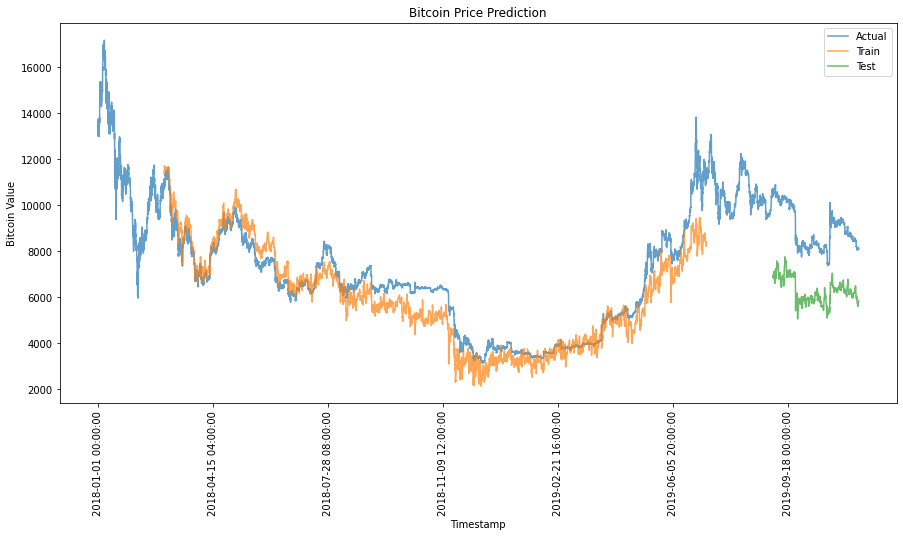

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(org_df.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('timestamp',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin Value')
plt.title('Bitcoin Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [16]:
print('-' * 50)
print('Experiment name:', expr_name)

print('-' * 50)
print('look_back days:', look_back/24)
print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(org_df.columns))


print('-' * 50)
print('Train Score: %.2f RMSE' % (trainScore_RMSE))
print('Test Score: %.2f RMSE' % (testScore_RMSE))

print('-' * 50)
print('Train Score: %.2f MAE' % (trainScore_MAE))
print('Test Score: %.2f MAE' % (testScore_MAE))

print('-' * 50)
print('Model summary:')
model.summary()

--------------------------------------------------
Experiment name: expr_7
--------------------------------------------------
look_back days: 60.0
lstm_layers: 32
epochs: 5
batch_size: 128
dataset features ['close_BTCUSDT', 'volume_BTCUSDT', 'close_LTCUSD', 'volume_LTCUSD', 'close_ETHUSD', 'volume_ETHUSD', 'gnews_flair', 'gnews_tb_polarity', 'gnews_tb_subjectivity', 'gnews_sid_pos', 'gnews_sid_neg']
--------------------------------------------------
Train Score: 847.67 RMSE
Test Score: 2698.95 RMSE
--------------------------------------------------
Train Score: 657.73 MAE
Test Score: 2662.41 MAE
--------------------------------------------------
Model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5632      
_________________________________________________________________
dense (Dense)                (None, 1)         